## Wiener-Filter Implementierung ##

### Degredation: Motion Blur ###

In [1]:
import os
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib.pyplot as plt
import cv2

In [2]:
# Funktion zur Erstellung der Störungsfilter-Matrix H(u) (Bewegungsunschärfe)
# Übergabeparamter:    [img_shape] -> Bildgröße (x und y);   [delta] -> Bewegung/Verschiebung in x- und y-Richtung
def motion_blur (img_shape, delta):
    T = 1  # 1s Belichtungszeit
    H = np.zeros(img_shape, dtype=np.complex128)
    for u1 in range(img_shape[0]):
        for u2 in range(img_shape[1]):     
            arg = u1*delta[0] + u2*delta[1]
            H[u1, u2] = T * np.sinc(arg) * np.exp(-1j*np.pi*arg)
    return H

# führt den Inversfilter aus und gibt das Bild im Ortsraum (inverse FFT) zurück
# Übergabeparamter:    [G] -> gestörtes Bild (Frequenzraum);   [H] -> Störungsfilter
def Inversefilter (G, H):
    F = G / H
    return ifft2(F) 

# Wienerfilter: mit Leistungsdichtespektren
# Übergabeparamter:    [F] -> Originalbild (Frequenzraum);   [H] -> Störungsfilter;   [N] -> Rauschen (Frequenzraum)
def Wienerfilter1 (F, H, N):
    return (np.conj(H)) / ((np.abs(H)**2) + ((abs(N)**2)/(abs(F)**2)))

# Wienerfilter: ohne Leistungsdichtespektren, mit Schätzung von K
# Übergabeparamter:    [F] -> Originalbild (Frequenzraum);   [K] -> Konstante K
def Wienerfilter2 (F, K):
    return (np.conj(H)) / ((np.abs(H)**2) + K)

# plottet alle Bilder
# Übergabeparamter:    [img_list] -> Liste der zu plottenden Bilder
def plot(img_list):
    img_list = np.abs(img_list) 
    labels = ['F (Original)', 'G (Motion Blur + Rauschen)', 'I1 (Inverse ohne Rauschen)', 'I2 (Inverse mit Rauschen)', 
              'Wiener Filter (ideal)', 'Wiener Filter (K geschätzt)']
    
    fig = plt.figure(figsize=(15, 15))
    for i in range(len(img_list)):
        fig.add_subplot(3, 2, i+1)
        plt.imshow(img_list[i], cmap = 'gray')
        plt.axis('off')
        plt.title(labels[i])
    plt.show()

## Bild einlesen ##

In [3]:
# Bild einlesen
fn = 'DIP.png'
img = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)

# FFT des Bildes 
F = fft2(img)

### 1. Störungsfilter: Bewegungsunschärfe H(u) ###

#### $H(u1, u2) = T sinc(u_1 \Delta x + u_2 \Delta y) e^{-j\pi (u_1 \Delta x + u_2 \Delta y)}$  ####

### 2. Rauschen: Gaußsches Rauschen N(u) ###

In [4]:
# Bewegungsunschärfe-Funktion (delta[0] -> vertikal, delta[1] -> horizontal)
H = motion_blur(img.shape ,delta=[0.05, 0.05])

# Gaussches Rauschen mit mu und sigma
noise = np.random.normal(0, 0.01, size=(img.shape[0],img.shape[1])) 
noise = np.clip(noise, 0, 255)
N = fft2(noise)

# Bild mit Bewegungsunschärfe
G1 = F * H      # ohne Rauschen
G2 = F * H + N  # mit  Rauschen

img_blurred = ifft2(G1) 
img_blurred_noise = ifft2(G2) 

## 1. Ansatz: Inversefilter ##

In [5]:
# inversefilter ohne Rauschen
img_inverse1 = Inversefilter(G1, H)

# inversefilter mit Rauschen
img_inverse2 = Inversefilter(G2, H)

## 2. Ansatz: Wiener-Filter ##

#### Wienerfilter1: ohne Schätzung der Leistungsdichtespektren ####
#### Wienerfilter2: mit Schätzung der Leistungsdichtespektren, dabei wird die Konstante K als Parameter mit übergeben ####

In [6]:
W1 = Wienerfilter1(F, H, N)

K = 0.000001
W2 = Wienerfilter2(F, K)

img_wf1 = ifft2(G2 * W1)
img_wf2 = ifft2(G2 * W2)

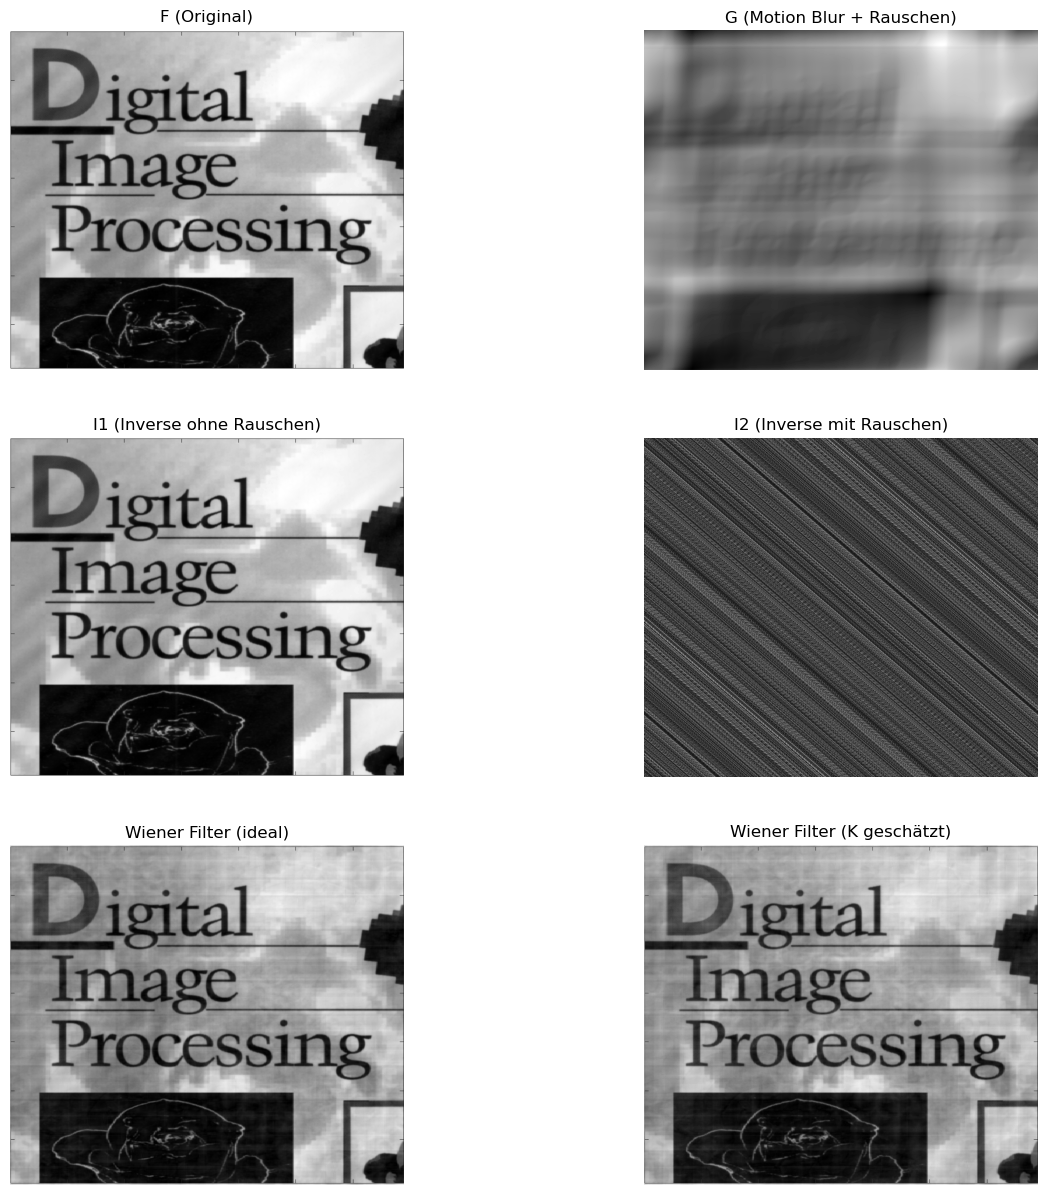

In [7]:
plot([img, img_blurred_noise, img_inverse1, img_inverse2, img_wf1, img_wf2])